In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yzfmrhpr because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 2

In [3]:
dataset = sklearn.datasets.make_swiss_roll(n_samples=300, noise=1.0, random_state=None)
print(min(dataset[1]),max(dataset[1]))
dataset = dataset[0][dataset[1]<10][:64,(0,2)]/10

4.785195608751626 14.063105098031082


In [4]:
dataset

array([[ 4.47228693e-01, -2.93238160e-01],
       [ 3.07995671e-01, -4.27861454e-01],
       [ 5.03640370e-01,  6.71881681e-01],
       [ 1.49859689e-02, -4.19495233e-01],
       [ 4.92680415e-01, -2.86312548e-01],
       [-8.49801720e-01, -4.29642006e-01],
       [-6.38065534e-01,  7.23476196e-01],
       [ 3.30831166e-01,  5.54708790e-01],
       [ 5.62165508e-01, -3.64057367e-01],
       [-1.12177821e-01,  7.42992261e-01],
       [ 7.04759028e-03, -3.73525421e-01],
       [ 4.81251429e-01,  5.86538909e-01],
       [ 6.78327054e-01,  3.23930338e-01],
       [ 4.11731278e-01,  5.71738441e-01],
       [ 5.63388104e-01,  4.62609661e-01],
       [ 4.21953128e-01, -3.72051573e-01],
       [ 5.03820025e-01,  3.54504003e-01],
       [ 7.99941676e-01,  1.89154242e-01],
       [ 6.97811347e-04,  8.97877754e-01],
       [-5.04049951e-01,  6.64708513e-01],
       [-9.25505200e-01,  1.03133109e-02],
       [-9.49692192e-01, -2.09444525e-01],
       [ 3.93727027e-01,  6.47638826e-01],
       [-1.

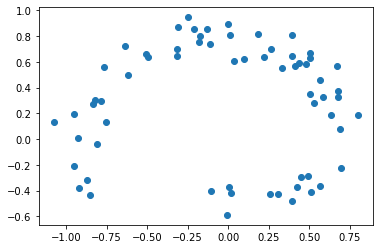

In [5]:
plt.scatter(dataset[:,0],dataset[:,1])

# 1D VAE Fit to Dataset

In [6]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device, alldata=False):
    """Sample Pair of Points from Trajectory"""
    if alldata:
        if batchsize is not None:
            raise "don't pass in batchsize if you're doing all data"
        traj_ids = range(all_points.shape[0])
        t1_ids = [0]
        t2_ids = t1_ids
    else:
        # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
        traj_ids = np.random.choice(all_points.shape[0], batchsize)
        t1_ids = np.random.choice(all_points.shape[1], batchsize)
        if predictive:
            t2_ids = np.random.choice(all_points.shape[1], batchsize)
        else:
            t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [7]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [8]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [9]:
testname = "pedagogical/swiss2d"

In [10]:
all_models=[]
all_exceptions = []
for curvreg in [0,0.1,1,10]:
    for secreg in [0]:
        if curvreg != 0 and secreg != 0:
            continue
        for beta in [0.0001,0.01]:
            for latentdim in [1]:
                for epsilon_scale_start in [2]:
                    try:
                        vae = make_vae(latent_dim=latentdim).to(device)
                        num_epochs = 600
                        savedir  = f'{testname}lat{latentdim}_secreg{secreg}_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                        print(savedir)
                        trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                            log_dir=savedir, lr=0.0005, annealingBatches=0, record_loss_every=50, loss_func = "gaussian")
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.5)
                        epoch = 0
                        epsilon_scale = epsilon_scale_start
                        for _ in range(num_epochs*3):
                            epoch+=1
                            # had an off-by-one error here before
                            # update values BEFORE training 501st element
                            if epoch % num_epochs == 1 and epoch > 1: 
                                scheduler.step()
                            embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                            is_error = embst[0]
                            if is_error:
                                raise Exception
                        sm.save_fcpassthrough_vae(vae, savedir)
                        print(savedir)
                        all_models.append(savedir)
                    except:
                        raise

pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.0001_20220201-182850
pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.0001_20220201-182850
pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.01_20220201-183013
pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.01_20220201-183013
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.0001_20220201-183133
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.0001_20220201-183133
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.01_20220201-183323
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.01_20220201-183323
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.0001_20220201-183513
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.0001_20220201-183513
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.01_20220201-183703
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.01_20220201-183703
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.0001_20220201-183853
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.0001_20220201-183853
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.01

In [11]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [12]:
for i, modelpath in enumerate(all_models):
    print(modelpath)
    vae = lm.load_model(modelpath)

pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.0001_20220201-182850
pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.01_20220201-183013
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.0001_20220201-183133
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.01_20220201-183323
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.0001_20220201-183513
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.01_20220201-183703
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.0001_20220201-183853
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.01_20220201-184044


pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.0001_20220201-182850
pedagogical/swiss2dlat1_secreg0_curvreg0_beta0.01_20220201-183013
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.0001_20220201-183133
pedagogical/swiss2dlat1_secreg0_curvreg0.1_beta0.01_20220201-183323
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.0001_20220201-183513
pedagogical/swiss2dlat1_secreg0_curvreg1_beta0.01_20220201-183703
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.0001_20220201-183853
pedagogical/swiss2dlat1_secreg0_curvreg10_beta0.01_20220201-184044


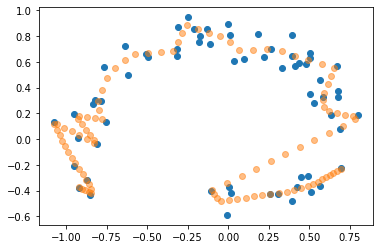

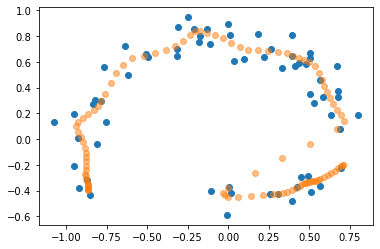

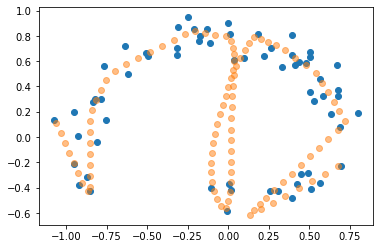

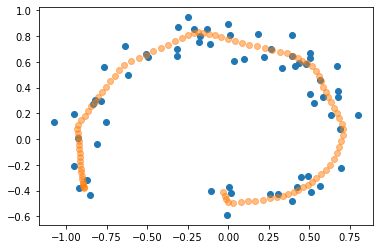

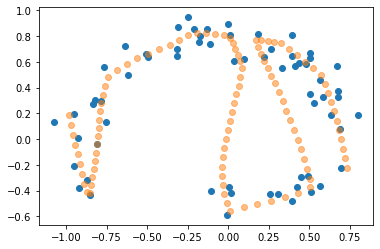

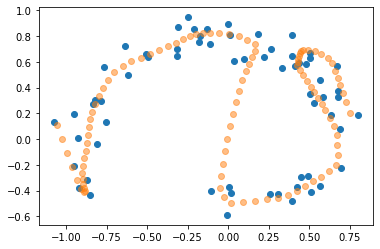

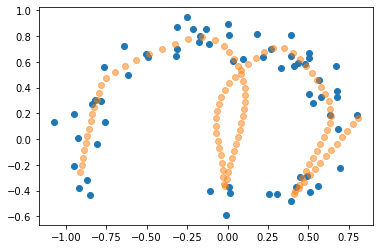

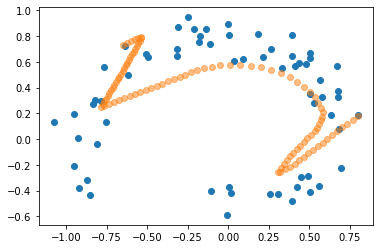

In [13]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = np.linspace(np.min(embeds[:,0]),np.max(embeds[:,0]),100).reshape((-1,1))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    plt.scatter(dataset[:,0],dataset[:,1]);
    plt.scatter(readout[:,0],readout[:,1], alpha=0.5);